# Tutorial on Conditional Variational Autoencoder (CVAE)

An **Autoencoder (AE)** is a neural network that learns to compress input data into a latent representation (often lower dimensional) and reconstruct it back, but its latent space is not structured for generation. A **Variational Autoencoder (VAE)** addresses this by enforcing the latent code to be close to a multivariate normal distribution, enabling smooth sampling and new data generation through a probabilistic encoder–decoder framework. A **Conditional VAE (CVAE)** further extends this idea by conditioning both the encoder and decoder on additional information (e.g., class labels), allowing controlled generation of data.


In [1]:
import torch
import torch.nn as nn

from torch.utils.data  import DataLoader
from torchvision.datasets import MNIST
import torch.nn.functional as F
import torchvision.utils


from tqdm import tqdm
import numpy as np
import random
#import matplotlib
#matplotlib.use('qtagg')
#%matplotlib ipympl
import matplotlib.pyplot as plt

## Setup MNIST the data

in this tutorial, we will use the MNIST dataset, a benchmark dataset of handwritten digits widely used in machine learning research. It contains **70,000** grayscale images of digits from **0 to 9**, each of size **28×28** pixels, split into **60,000** training samples and **10,000** test samples.

In [2]:
# where to save the data
data_dir  = 'Data'
bs_train  = 1000
bs_test   = 1000

# load the data
transform    = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset = MNIST(root= data_dir, train=True, download=False,transform=transform)
test_dataset  = MNIST(root= data_dir, train=False, download=False,transform=transform)

# --- loaders
test_dataloader  = DataLoader(test_dataset, batch_size=bs_test, shuffle=False, num_workers=0,pin_memory=False)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs_train, shuffle=True,num_workers=0,pin_memory=False)



Let's visualise some data samples from MNIST

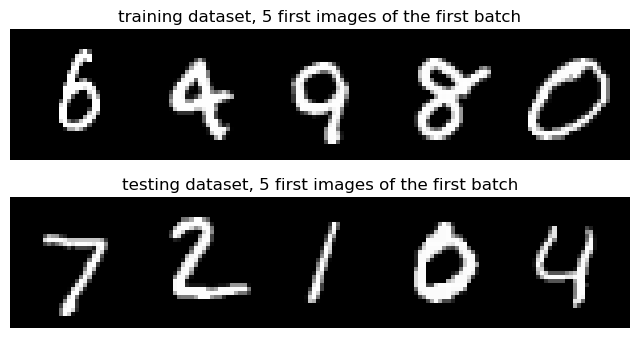

In [3]:
#%% create a figure showing one image per class
figure = plt.figure(figsize=(8, 4))
cols, rows = 3, 3

data,cond = next(iter(train_dataloader))
from torchvision.utils import make_grid
displayImage = make_grid(data[0:5], nrow = 5).permute(1, 2, 0) # need to scale back for display the effect of the normalisation
figure.add_subplot(2, 1, 1)
plt.title('training dataset, 5 first images of the first batch')
plt.axis("off")
plt.imshow(displayImage)

data,cond = next(iter(test_dataloader))
displayImage = make_grid(data[0:5], nrow = 5).permute(1, 2, 0) # need to scale back for display the effect of the normalisation
figure.add_subplot(2, 1, 2)
plt.title('testing dataset, 5 first images of the first batch')
plt.axis("off")
plt.imshow(displayImage)

plt.savefig('task1_fig1', dpi=300, transparent=False)
plt.show()

# Setup CVAE Model   

A **CVAE** consists of two main components: an **encoder** and a **decoder**, both conditioned on auxiliary information (e.g., class labels).  

- **Encoder** $q_\phi(z \mid x, y)$: takes an input sample $x$ and its condition $y$, and maps them to the parameters of a latent distribution (mean $\mu$ and variance $\sigma^2$. From this distribution, a latent variable $z$ can be sampled. 

- **Decoder** $p_\theta(x \mid z, y)$: takes the sampled latent variable $z$ together with the condition $y$, and reconstructs the input data $\hat{x}$.  


Let start by coding the encoder network that converts 28x28 images into a latent vector of dimension z_dim

In [4]:
# Create an encoder to encode the 1x28x28 images into a latent vector of dimension z_dim
class cEncoder(nn.Module):
    def __init__(self, z_dim, num_classes):
        super(cEncoder, self).__init__()
        self.z_dim = z_dim
        self.num_classes = num_classes
        # Define the encoder layers
        self.encoder_backbone = nn.Sequential(
            # Layer 1: 1x28x28 -> 16x14x14
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # Layer 2: 16x14x14 -> 32x7x7
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # Layer 3: 32x7x7 -> 64x4x4
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # Layer 5: 64x4x4 -> 256x1x1
            nn.Conv2d(64, 256, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
            # Flatten and project to z_dim
            nn.Flatten(),  # 256*1*1 = 256
        )
        self.encoder_head = nn. Sequential(
           nn.Linear(256+num_classes, 2*z_dim)
        )
         
    def forward(self, x, cond):
        # x shape: (batch_size, 1, 28, 28)
        x = self.encoder_backbone(x)
        x = torch.cat([x, cond], dim=1)
        x = self.encoder_head(x)
        mu,logvar = torch.chunk(x, 2, dim=1)
        return mu,logvar

Now build a decoder that convert a latent vector with z_dim into an image.

In [5]:
class cDecoder(nn.Module):
    def __init__(self, z_dim, num_classes):
        super(cDecoder, self).__init__()
        self.z_dim = z_dim
        self.num_classes = num_classes
        self.decoder_input =  nn.Sequential(
            # Project latent vector to a feature map
            nn.Linear(z_dim + num_classes, 256),
            nn.ReLU(),
        )
        self.decoder_backbone = nn.Sequential(
            nn.Unflatten(1, (256, 1, 1)),  # Reshape to (256, 1, 1)
            # Layer 1: 256x1x1 -> 64x4x4
            nn.ConvTranspose2d(256, 64, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
            # Layer 3: 64x4x4 -> 32x7x7
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            # Layer 4: 32x7x7 -> 16x14x14
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            # Layer 5: 16x14x14 -> 1x28x28
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Output in [0, 1] for pixel values
        )

    def forward(self, z, cond):
        z = torch.cat([z, cond], dim=1)
        z = self.decoder_input(z)
        x_hat  = self.decoder_backbone(z)
        # z shape: (batch_size, z_dim)
        return x_hat

# CVAE Loss

The CVAE is trained by maximizing the conditional evidence lower bound (ELBO) and in practice is implemented as:  

$$
\mathcal{L}_{CVAE} = \underbrace{\frac{1}{N}\sum_{i=1}^{N} (x_i - \hat{x}_i)^2}_{\text{MSE reconstruction loss}} 
+ \underbrace{D_{\text{KL}}\big(q_\phi(z \mid x, y) \,\|\, p(z)\big)}_{\text{KL divergence}}
$$  

- The **reconstruction term** corresponds to the expected log-likelihood in the ELBO and is implemented here as **Mean Squared Error (MSE)**.  
- The **KL divergence term** regularizes the latent distribution to stay close to the prior, typically a standard multivariate normal distribution.  

This encoder–decoder formulation allows the CVAE to generate new samples of $x$ that are consistent with a chosen condition $y$.

Let's code this loss function

In [6]:
def compute_loss(x, x_hat, mu, logvar, beta=0.1):
    """
    Compute the reconstruction loss for the autoencoder.
    """

    # Reconstruction loss (MSE)
    recon_loss = 100*F.mse_loss(x_hat, x, reduction='mean')

    # For standard autoencoder, KL divergence is 0
    if beta == 0:
        kl_loss = 0.0
    else:
        kl_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))

    # Total loss
    total_loss = recon_loss + beta * kl_loss

    return total_loss, recon_loss, kl_loss

### Sampling Latent Variables: The Reparameterization Trick

In a CVAE (as well as in VAE), the encoder outputs a **mean** $\mu$ and **variance** $\sigma^2$ for the latent variable $z$, and we want to sample:

$$
z \sim \mathcal{N}(\mu, \sigma^2)
$$

Directly sampling $z$ would break backpropagation because randomness is not differentiable.  
The **reparameterization trick** solves this by expressing the sampling of $z$ as a deterministic function of $\mu$, $\sigma$, and random noise $\epsilon \sim \mathcal{N}(0, 1)$:

$$
z = \mu + \sigma \odot \epsilon
$$

Now the sampling is differentiable with respect to $\mu$ and $\sigma$, allowing gradients to flow through the network during training.


Now, we can build the CVAE class with the reparameterization trick.

In [7]:
class cVAE(nn.Module):
    def __init__(self, z_dim, num_classes):
        super(cVAE, self).__init__()
        self.encoder = cEncoder(z_dim, num_classes)
        self.decoder = cDecoder(z_dim, num_classes)
        self.z_dim =  z_dim
        self.num_classes = num_classes
    
    def encode(self,x,cond):
        return self.encoder(x,cond)

    def decode(self,z,cond):
        return self.decoder(z,cond)
    
    def forward(self, x, cond):
        mu,logvar = self.encoder(x, cond)
        sigma = torch.exp(0.5 * logvar)
        eps = torch.randn_like(sigma)
        z = mu + eps * sigma
        x_recon = self.decoder(z, cond)
        return x_recon,mu,logvar

create a CVAE model and check it

In [ ]:
# parameters
z_dim = 8

# create the model and move it to the GPU
model = cVAE(z_dim,num_classes = 10)
device = torch.device('cuda:0')
model = model.to(device)

print(model)

print("\n---total number of parameters:")
Nparams = sum(p.numel() for p in model.parameters())
print(Nparams)
print("---total number of trainable parameters:")
Nparams_train = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(Nparams_train)
print()


cVAE(
  (encoder): cEncoder(
    (encoder_backbone): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(64, 256, kernel_size=(4, 4), stride=(1, 1))
      (7): ReLU()
      (8): Flatten(start_dim=1, end_dim=-1)
    )
    (encoder_head): Sequential(
      (0): Linear(in_features=266, out_features=16, bias=True)
    )
  )
  (decoder): cDecoder(
    (decoder_input): Sequential(
      (0): Linear(in_features=18, out_features=256, bias=True)
      (1): ReLU()
    )
    (decoder_backbone): Sequential(
      (0): Unflatten(dim=1, unflattened_size=(256, 1, 1))
      (1): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(1, 1))
      (2): ReLU()
      (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    

# CVAE Training loop

Training a CVAE follows a **standard training loop**. The only particularity is the handling of the **condition** $y$, which is provided to both the encoder and decoder:

- **For each epoch**:
  - **Train**:
    - Get a batch of data $(x, y)$ from the training set.
    - Run the batch through the CVAE model to obtain the reconstructed output $\hat{x}$ and latent distribution parameters $(\mu, \sigma)$.
    - Compute the **CVAE loss**
    - Backpropagate and update model parameters with an optimizer.
    
  - **Validate**:
    - Evaluate the model on a validation set using reconstruction loss to monitor progress. At this time, we will also aoutput some reconstructed sampels.

In [9]:
def get_batch(batch, device,f_train=True,num_classes=10):
    # f_train to select if this is a batch for training or testing
    # not used here, but will be useful later
    x  = batch[0].to(device)
    cond  = batch[1].to(device)
    cond = F.one_hot(cond, num_classes=num_classes).float()
    return x,cond

def training_loop(model,train_dataloader,test_dataloader,nb_epoch):
    
    # optimizer
    import torch.optim as optim
    optimizer = optim.AdamW(model.parameters(),
                            lr = 0.001,
                            eps=1e-5,fused=False,betas=(0.75,0.99))
    # loop over epochs
    losses = []
    for epoch in range(nb_epoch):
        print(f'----- Epoch {epoch+1}')
    
        # --------- train
        model.train()
        
        loss_train = 0
        idx  = 0
        pbar = tqdm(iterable=train_dataloader, unit="batch",desc='training', colour='GREEN')
        for batch in pbar:
            idx += 1
            if idx>100000:
                break

            x,cond = get_batch(batch, device,f_train=True)
    
            optimizer.zero_grad()
            x_hat,mu,logvar = model(x,cond)
            
            # compute the loss
            total_loss, recon_loss, kl_loss = compute_loss(x, x_hat,mu,logvar)
            loss_train += total_loss
    
            # backprop
            total_loss.backward()
            optimizer.step()
            
        loss_train /= idx
    
        
        # --------- test
        model.eval()
        
        loss_test = 0
        idx  = 0
        correct = 0
        N = 0
        pbar = tqdm(iterable=test_dataloader, unit="batch",desc=' testing', colour='CYAN')
        for batch in pbar:
            idx += 1
            if idx>20000:
                break

            x,cond = get_batch(batch, device,f_train=False)

            with torch.no_grad():
                mu,logvar = model.encode(x,cond)
                x_hat = model.decode(mu,cond)
                
            
            # compute the loss
            total_loss, recon_loss, kl_loss = compute_loss(x, x_hat,mu,logvar)
            loss_test += total_loss
            
        loss_test /= idx
    
        # # create an image for display
        toDisp = torch.cat((x[:10],x_hat[:10]))
        displayTraining = make_grid(toDisp, nrow = 10).permute(1, 2, 0).cpu() 
    
        # --------- update losses 
        losses.append([loss_train.detach().cpu(),loss_test.detach().cpu()])
        print(f'losses training: {losses[-1][0]}, testing: {losses[-1][1]}')
    
        # --- show reconstucted images
        #figure.add_subplot(2, 1, 2)
        plt.imshow(displayTraining)
        plt.title('testing data and reconstruction')
        plt.axis("off")
        plt.show()

    return losses

----- Epoch 1


 testing: 100%|██████████| 10/10 [00:01<00:00,  8.71batch/s]

losses training: 10.449056625366211, testing: 6.878579616546631


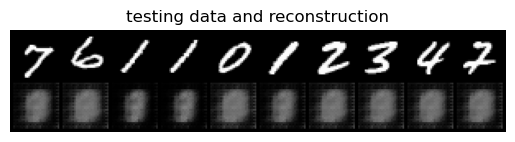

----- Epoch 2


 testing: 100%|██████████| 10/10 [00:01<00:00,  8.86batch/s]

losses training: 6.1589131355285645, testing: 5.3850860595703125


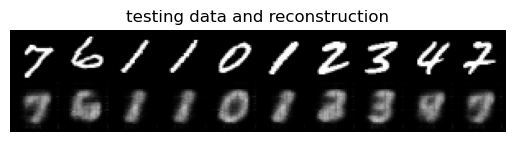

----- Epoch 3


 testing: 100%|██████████| 10/10 [00:01<00:00,  8.45batch/s]

losses training: 5.025691509246826, testing: 4.427126884460449


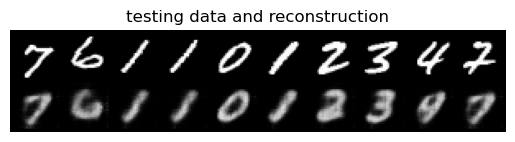

----- Epoch 4


 testing: 100%|██████████| 10/10 [00:01<00:00,  8.90batch/s]

losses training: 4.48389196395874, testing: 4.057509422302246


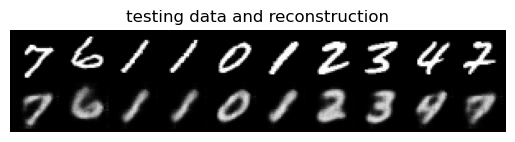

----- Epoch 5


 testing: 100%|██████████| 10/10 [00:01<00:00,  8.87batch/s]

losses training: 4.1839423179626465, testing: 3.787932872772217


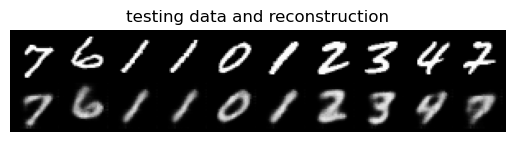

----- Epoch 6


 testing: 100%|██████████| 10/10 [00:01<00:00,  8.85batch/s]

losses training: 3.966066598892212, testing: 3.577302932739258


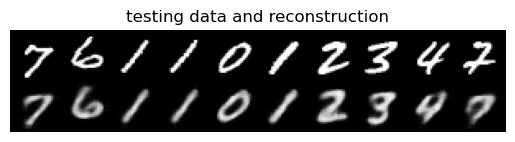

----- Epoch 7


 testing: 100%|██████████| 10/10 [00:01<00:00,  8.83batch/s]

losses training: 3.813500165939331, testing: 3.452934980392456


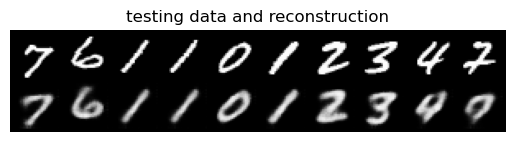

----- Epoch 8


 testing: 100%|██████████| 10/10 [00:01<00:00,  8.76batch/s]

losses training: 3.6901895999908447, testing: 3.267490863800049


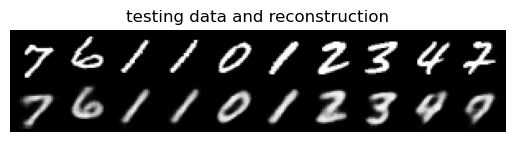

----- Epoch 9


 testing: 100%|██████████| 10/10 [00:01<00:00,  8.83batch/s]

losses training: 3.5839192867279053, testing: 3.17537522315979


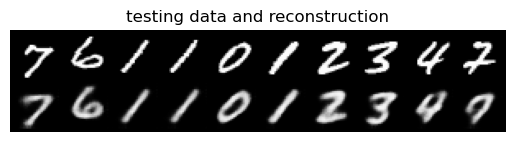

----- Epoch 10


 testing: 100%|██████████| 10/10 [00:01<00:00,  8.83batch/s]

losses training: 3.5028762817382812, testing: 3.1112496852874756


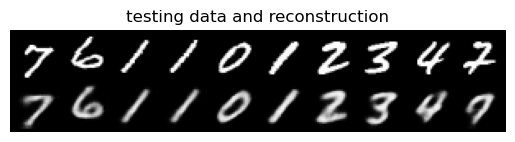

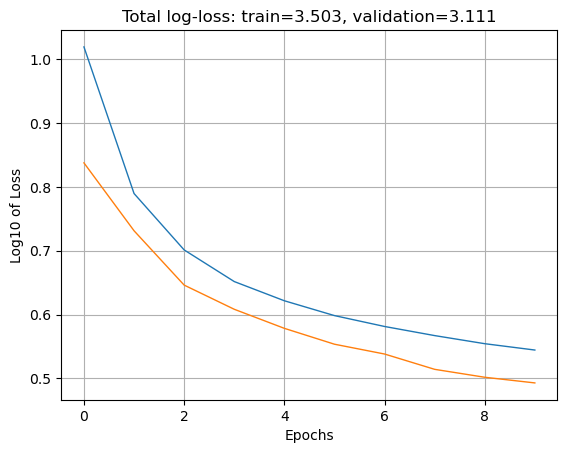

In [ ]:
# start the training
losses = training_loop(model,train_dataloader,test_dataloader,nb_epoch=50)

# create the figure with a plot of the loss
plt.plot(np.log10(losses),label= ['training','validation'],linestyle = 'solid', linewidth=1.0)
plt.title("Total log-loss: train={0:.3f}, validation={1:.3f}".format(losses[-1][0],losses[-1][1]))
plt.xlabel("Epochs"); plt.ylabel("Log10 of Loss");
plt.grid(True)
plt.show()


## Generating Samples with a Trained CVAE

After training, we can use the CVAE to generate **new samples** conditioned on a desired label $y$.  
The process is straightforward:

- Choose a condition $y$ (e.g., a digit class in MNIST).
- Sample a latent vector $z$ from the prior distribution $\mathcal{N}(0, I)$.
- Pass $(z, y)$ through the decoder to generate a new sample $\hat{x}$.

Compared to a plain VAE, where generation is unconstrained, the CVAE allows us to control **what is generated** and **how it looks**:

- **The condition $y$:** determines the class or type of data (e.g., digit “7”).  
- **The latent vector $z$:** introduces variation within that class (e.g., different handwriting styles of “7”).  

👉 By fixing $y$ and varying $z$, we can obtain many diverse samples of the same class.  
👉 By fixing $z$ and varying $y$, we can see how the same “style” is expressed across different classes.


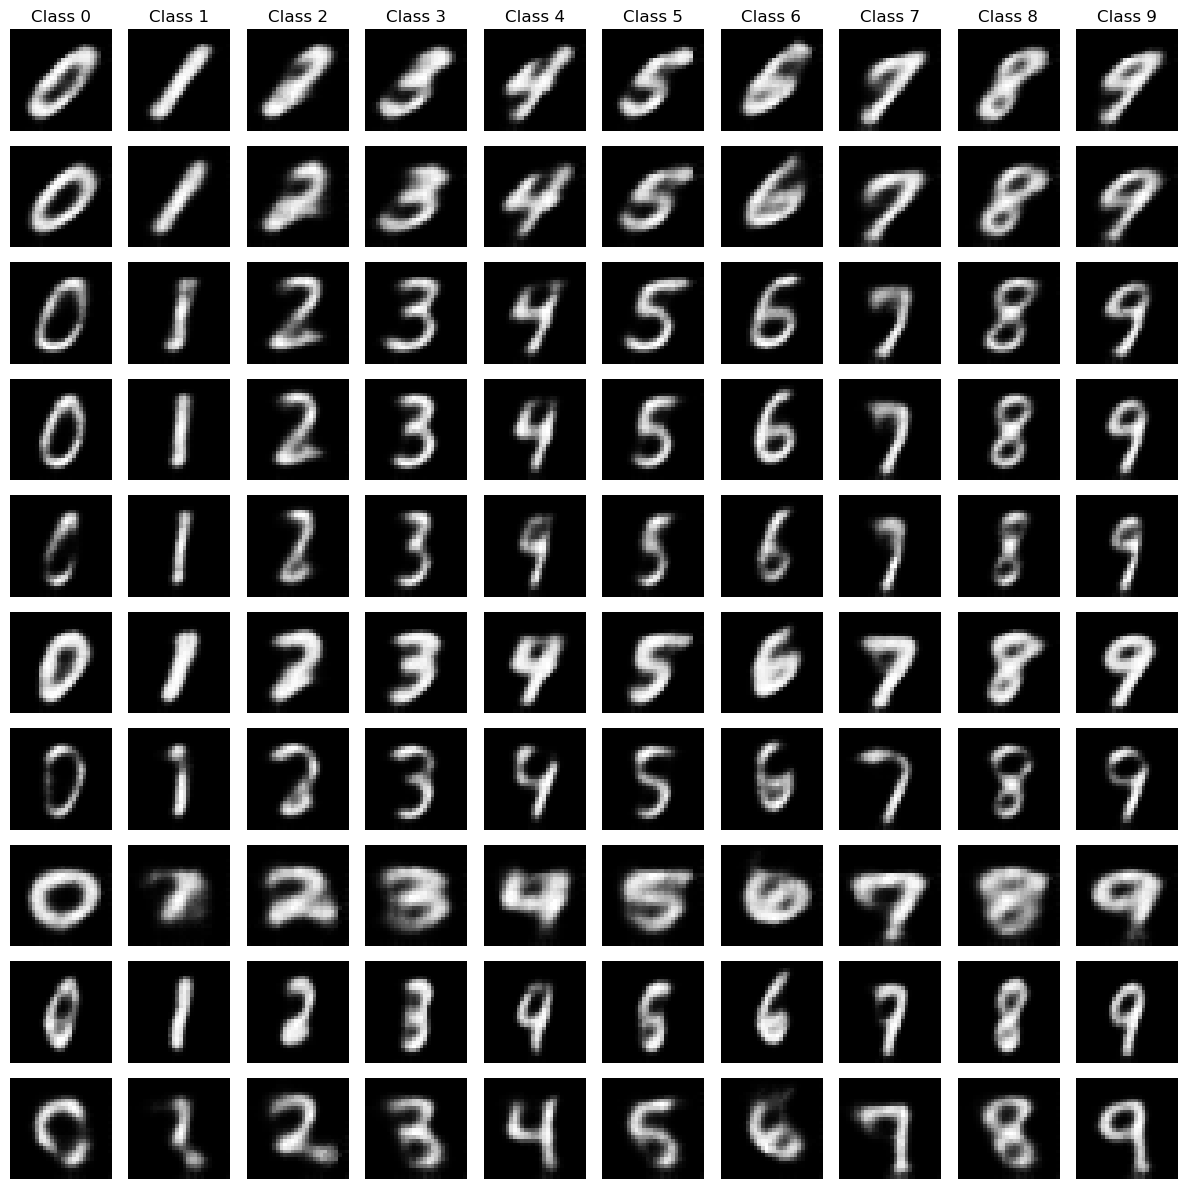

In [20]:
# number of samples per class
num_samples = 10

model.eval()
with torch.no_grad():

    # Define all 10 conditions
    all_conditions = torch.eye(10).to(device)

    # sample different latent vector from prior
    z_cond = torch.randn(num_samples, z_dim).to(device)

    all_xhat = []
    for cond in all_conditions:    
        # generate new samples for each class
        x_hat = model.decode(z_cond, cond.repeat(z_cond.shape[0],1))
        all_xhat.append(x_hat)    
    all_xhat = torch.stack(all_xhat)
    
# Plot the grid
fig, axes = plt.subplots(num_samples, 10, figsize=(12, 12))
for c in range(10):
    for i in range(num_samples):
        axes[i, c].imshow(all_xhat[c, i].squeeze(), cmap='gray')             
        if i == 0:
            axes[i, c].set_title(f'Class {c}')
        if c == 0:
            axes[i, c].set_ylabel(f'Sample {i}')
        axes[i, c].axis('off')   
plt.tight_layout()
plt.show()


## Classification via Reconstruction with Conditions

A CVAE can be used for classification by exploiting its **conditional generation structure**. The idea is simple:

1. **Loop over all possible conditions (classes) $y_c$:**
    - Feed the input $x$ and the candidate condition $y_c$ into the **encoder** to get the latent vector $z_c \sim q(z|x, y_c)$.  
    - Pass $(z_c, y_c)$ into the **decoder** to reconstruct $\hat{x}_c \sim p(x|z_c, y_c)$.

2. **Measure reconstruction quality** for each candidate condition, e.g., using **mean squared error (MSE)**:
$$
\text{error}_c = \| x - \hat{x}_c \|^2
$$

3. **Predict the class** corresponding to the **lowest reconstruction error**:
$$
\hat{y} = \arg\min_c \text{error}_c
$$

### Intuition

- The CVAE is trained to reconstruct inputs conditioned on the correct label.  
- Feeding an incorrect condition into the encoder and decoder produces a latent code $z_c$ that fails to reconstruct the input accurately.  
- The correct condition results in the **best reconstruction**, naturally giving a classification.  

> Notes:
>- This method is **computationally heavier**, as the encoder and decoder are evaluated for every possible class.  
>- Works best when the CVAE is **well-trained**, ensuring reconstruction errors clearly separate classes.


Classifying:: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


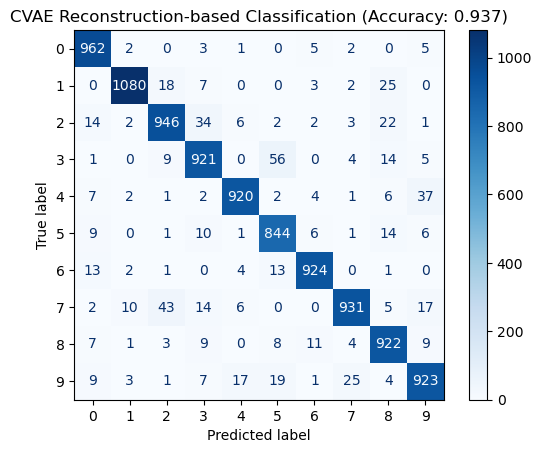

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
with torch.no_grad():
    # iterate over batches of the test
    all_labels, all_preds = [], []
    for batch in tqdm(test_dataloader, desc="Classifying:"):    
        x, cond = get_batch(batch, device, f_train=False)            
        errors = []
        for y_class in range(10):
            # Create one-hot condition for all samples in batch
            y_onehot = F.one_hot(torch.tensor([y_class]*x.shape[0], device=device), 10).float()
            
            # Encode and decode conditioned on y_class
            mu, _ = model.encode(x, y_onehot)
            x_hat = model.decode(mu, y_onehot)
            
            # Compute reconstruction error (MSE)
            error = ((x - x_hat)**2).flatten(1).sum(1)  # shape [batch_size]
            errors.append(error)
        
        # select the class with lower reconstruction error
        errors = torch.stack(errors, dim=1)  # shape [batch_size, n_classes]
        preds = torch.argmin(errors, dim=1)
        
        all_preds.append(preds.cpu())
        all_labels.append(torch.argmax(cond, dim=1))

# Concatenate all predictions and labels
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
Accuracy = cm.diagonal().sum()/float(cm.sum())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"CVAE Reconstruction-based Classification (Accuracy: {Accuracy:.3f})")
plt.show()


## The Latent space 

First, let's look at the distibution of the latent variables

In [69]:
# compute the latent for the test dataset
latent_mu = []
latent_std = []
classes = []

pbar = tqdm(iterable=test_dataloader, unit="batch",desc=' testing', colour='CYAN')
for batch in pbar:
    x,cond = get_batch(batch, device,f_train=False)
    with torch.no_grad():
        mu,logvar = model.encode(x,cond)
    latent_mu.append(mu.cpu().numpy())
    latent_std.append(torch.exp(0.5 * logvar).cpu().numpy())
    classes.append(torch.argmax(cond, dim=1).cpu().numpy())
# Concatenate all latent variables
latent_mu = np.concatenate(latent_mu, axis=0)
latent_std = np.concatenate(latent_std, axis=0)
classes = np.concatenate(classes, axis=0)

 testing: 100%|██████████| 10/10 [00:01<00:00,  9.49batch/s]


Visualisation of the latent

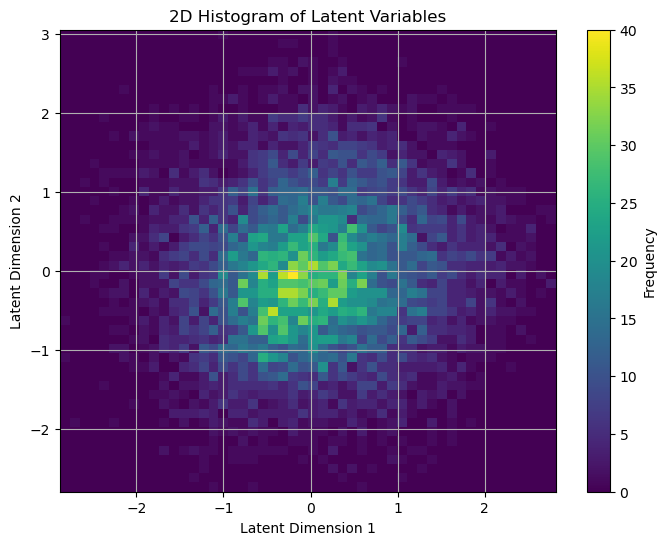

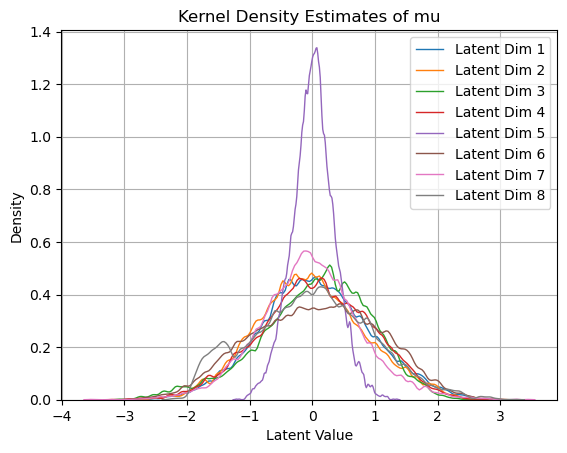

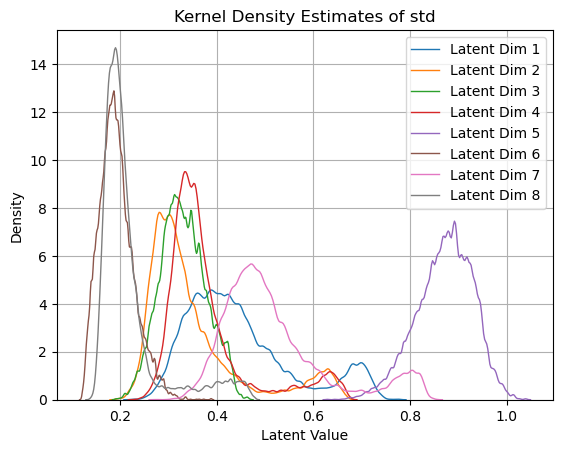

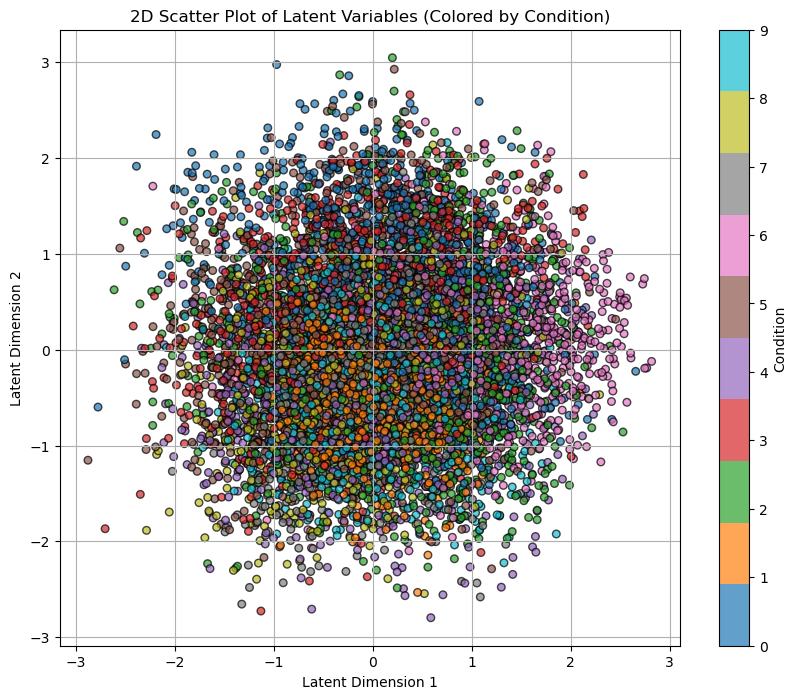

In [70]:

# Plot
plt.figure(figsize=(8, 6))
plt.hist2d(latent_mu[:, 0], latent_mu[:, 1], bins=50, cmap='viridis')
plt.colorbar(label='Frequency')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Histogram of Latent Variables')
plt.grid(True)
plt.show()


# Plot a histogram for each latent dimension on the same axis
import seaborn as sns
# for mu
for i in range(z_dim):
    sns.kdeplot(
        latent_mu[:, i],
        label=f'Latent Dim {i + 1}',
        linewidth=1,
        bw_adjust=.3
    )
# Add labels and legend
plt.xlabel('Latent Value')
plt.ylabel('Density')
plt.title('Kernel Density Estimates of mu')
plt.legend()
plt.grid(True)
plt.show()

# for std
for i in range(z_dim):
    sns.kdeplot(
        latent_std[:, i],
        label=f'Latent Dim {i + 1}',
        linewidth=1,
        bw_adjust=.3
    )
# Add labels and legend
plt.xlabel('Latent Value')
plt.ylabel('Density')
plt.title('Kernel Density Estimates of std')
plt.legend()
plt.grid(True)
plt.show()


# Create a scatter plot using the first two latent dimensions
plt.figure(figsize=(10, 8))

# Scatter plot, color-coded by condition
cmap = plt.get_cmap('tab10', 10)  # 10 distinct colors
scatter = plt.scatter(
    latent_mu[:, 0],  # First latent dimension
    latent_mu[:, 1],  # Second latent dimension
    c=classes,        # Color by condition
    cmap=cmap,      # Color map
    alpha=0.7,           # Transparency
    edgecolor='k',       # Edge color
    s=30                 # Point size
)

# Add a colorbar
plt.colorbar(scatter, label='Condition')

# Add labels and title
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Scatter Plot of Latent Variables (Colored by Condition)')
plt.grid(True)
plt.show()

Let's look at the latent vectors to better understand where they are in latent space. We can compute the norm of the latent vectors and display their histogram. We can also pick a direction and show the histogram of the angle that each latent vectors makes with that direction. 

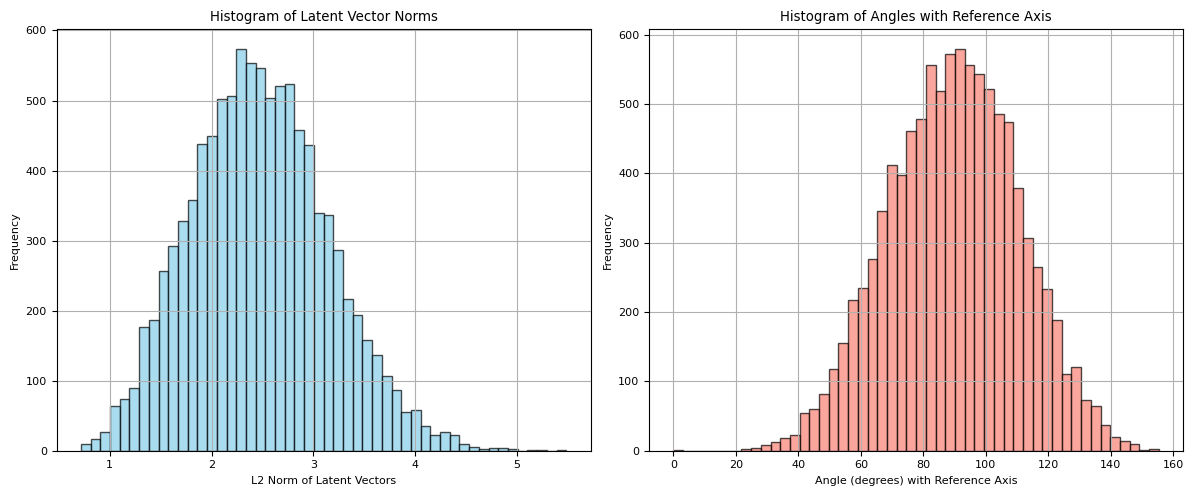

In [14]:
# Compute the L2 norm (Euclidean norm) of each latent vector
norms = np.linalg.norm(latent_mu, axis=1)

# Choose a reference axis (e.g., the first latent vector)
reference_axis = latent_mu[0]

# Compute the angle between each latent vector and the reference axis
def compute_angle(v1, v2):
    # Normalize the vectors
    v1_normalized = v1 / np.linalg.norm(v1)
    v2_normalized = v2 / np.linalg.norm(v2)
    # Compute the dot product
    dot_product = np.dot(v1_normalized, v2_normalized)
    # Ensure the dot product is within [-1, 1] to avoid numerical errors
    dot_product = np.clip(dot_product, -1.0, 1.0)
    # Compute the angle in radians
    angle_rad = np.arccos(dot_product)
    # Convert to degrees
    angle_deg = np.degrees(angle_rad)
    return angle_deg

angles = np.array([compute_angle(latent_mu[i], reference_axis) for i in range(len(latent_mu))])

# Plot histogram of norms
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(norms, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('L2 Norm of Latent Vectors')
plt.ylabel('Frequency')
plt.title('Histogram of Latent Vector Norms')
plt.grid(True)

# Plot histogram of angles
plt.subplot(1, 2, 2)
plt.hist(angles, bins=50, color='salmon', edgecolor='black', alpha=0.7)
plt.xlabel('Angle (degrees) with Reference Axis')
plt.ylabel('Frequency')
plt.title('Histogram of Angles with Reference Axis')
plt.grid(True)

plt.tight_layout()
plt.show()

We can see that all the latent vectors have a norm > 1, with an average of around $\sqrt{z_{dim}}$: so the centre of the latent space is empty. This is somehow counterintuitive since every latent is distributed around 0!

Furthermore, every latent vector is in average perpendicular with any given directions. You can change the chosen direction and verify that the histrogram is always centred around 90 degrees. 